# **BirdCLEF 2025 Data Preprocessing Notebook**

In [1]:
import os
import cv2
import math
import time
import librosa
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import sys
import os
import numpy as np
from datetime import datetime
import pytz
import random
import torch
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedGroupKFold

from joblib import Parallel, delayed



In [2]:
class DatasetConfig:
    def __init__(self, kaggle_notebook=False, debug=False):
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
            self.RAW_DIR = "/kaggle/input/birdclef-2025/"
            self.PROCESSED_DIR = ""
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'


        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 16
        self.N_MELS = 128
        self.FMIN = 20
        self.FMAX = 16000
        self.N_MAX = 50 if self.debug else None        
        self.N_JOBS = 8
        self.LOAD_ENGINE = 'torchaudio'  # librosa or torchaudio
        self.SKIP_RESIZE = False  # resizeしないならTrue
        self.seed = 42
        self.n_fold = 5
        self.num_rare_samples = 50 # これ以下のサンプル数のspeciesはrare speciesとして扱う
        self.is_crop_aug = False
            

In [3]:
config = DatasetConfig(kaggle_notebook=False, debug=False)

In [4]:
def set_seed(seed=42):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

set_seed(config.seed)

In [5]:
print(f"Debug mode: {'ON' if config.debug else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(f'{config.RAW_DIR}/taxonomy.csv')
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

print("Loading training metadata...")
train_df = pd.read_csv(f'{config.RAW_DIR}/train.csv')

Debug mode: OFF
Max samples to process: ALL
Loading taxonomy data...
Loading training metadata...


In [6]:
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')
working_df = train_df.copy()
working_df['target'] = working_df.primary_label.map(label2id)
working_df['filepath'] = config.RAW_DIR + '/train_audio/' + working_df.filename
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))
working_df["crop_strategy"] = "center"
total_samples = min(len(working_df), config.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')
print(f'Samples by class:')
print(working_df['class'].value_counts())

# 音源の長さ， foldをロードして追加． 
duration_fold_df = pd.read_csv("../data/processed/train_mel0413.csv")[["filename", "duration_sec", "fold"]]
working_df = working_df.merge(duration_fold_df, on="filename", how="left")

missing = working_df["duration_sec"].isna().sum()
print(f"✅ Added 'duration_sec'. Missing values: {missing}")

Found 206 unique species
Total samples to process: 28564 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64
✅ Added 'duration_sec'. Missing values: 0


In [7]:
display(working_df)

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,target,filepath,samplename,class,crop_strategy,duration_sec,fold
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,0,../data/raw//train_audio/1139490/CSA36385.ogg,1139490-CSA36385,Insecta,center,98.853375,1
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,0,../data/raw//train_audio/1139490/CSA36389.ogg,1139490-CSA36389,Insecta,center,96.537719,3
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,../data/raw//train_audio/1192948/CSA36358.ogg,1192948-CSA36358,Insecta,center,116.599812,0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,../data/raw//train_audio/1192948/CSA36366.ogg,1192948-CSA36366,Insecta,center,105.446313,1
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,../data/raw//train_audio/1192948/CSA36373.ogg,1192948-CSA36373,Insecta,center,103.631469,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0,205,../data/raw//train_audio/ywcpar/iNat77392.ogg,ywcpar-iNat77392,Aves,center,3.392000,3
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0,205,../data/raw//train_audio/ywcpar/iNat78624.ogg,ywcpar-iNat78624,Aves,center,7.659688,4
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0,205,../data/raw//train_audio/ywcpar/iNat789234.ogg,ywcpar-iNat789234,Aves,center,7.666656,3
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0,205,../data/raw//train_audio/ywcpar/iNat819873.ogg,ywcpar-iNat819873,Aves,center,27.036750,1


In [8]:
working_df["valid_start_sec"] = 0
working_df["valid_end_sec"] = working_df["duration_sec"]

In [9]:
# 手動で人の声除去

# 4. 特定のファイルの valid_start_sec を変更
# 特定のファイル（最初にスペイン語が含まれる）
spanish_intro_filenames = [
    '50186/CSA28885.ogg',
    '52884/CSA14875.ogg'
]
# valid_start_sec を 4.0 に変更
working_df.loc[
    working_df['filename'].isin(spanish_intro_filenames),
    'valid_start_sec'
] = 4.0


# 途中で人の声のみになるので除去
voice_only_ranges = {
    '476537/CSA35459.ogg': 134,  # 2分14秒 = 134秒
    '476537/CSA35461.ogg': 259,  # 4分19秒 = 259秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# Eliana Barona- Cortés　の音源．話している部分．いらない部分
# 24292/CSA34649.ogg 2min8以降
# 24292/CSA34651.ogg 1min33以降
# 50186/CSA34622.ogg 21s以降
# 50186/CSA34678.ogg 43s以降
voice_only_ranges = {
    '24292/CSA34649.ogg': 128,   # 2分8秒 = 128秒
    '24292/CSA34651.ogg': 93,    # 1分33秒 = 93秒
    '50186/CSA34622.ogg': 21,    # 21秒
    '50186/CSA34678.ogg': 43,    # 43秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec

# Alexandra Butrago-Cardona の音源チェック
# 話している部分．いらない部分
# 24292/CSA35021.ogg 36s以降
# 52884/CSA34947.ogg 13s以降
voice_only_ranges = {
    '24292/CSA35021.ogg': 36,    # 36秒
    '52884/CSA34947.ogg': 13,     # 13秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# Fabio A. Sarria-S の音声は 0〜7秒 だけ使用可能に設定．後半はただの説明なので
fabio_filenames = train_df.loc[
    train_df['author'] == "Fabio A. Sarria-S", 'filename'
].tolist()
# 
working_df.loc[
    working_df['filename'].isin(fabio_filenames), 'valid_end_sec'
] = 7.0

#  Fabioの解説で，必ずしも7secではないもの
fabio_override = {
    "48124/CSA36346.ogg": 24.0,
    "52884/CSA36344.ogg": 55.0,
    "52884/CSA36342.ogg": 14.0,  # ← 追加分
}

for fname, end_sec in fabio_override.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# crop戦略は基本center
working_df["crop_strategy"] = "center"

In [10]:
# safezoneをworking_dfに反映．

# safe_zoneを準備（すでに"checked"のみ、重複除去済み）
safe_zone = pd.read_csv("../data/processed/safezone_1000_0501.csv")
safe_zone = safe_zone[safe_zone["check"] == "checked"]
safe_zone = safe_zone.drop_duplicates(subset=["filename"])

# start, endをfloatに変換
safe_zone["start"] = pd.to_numeric(safe_zone["start"], errors="coerce")
safe_zone["end"] = pd.to_numeric(safe_zone["end"], errors="coerce")

# safe_zoneから必要なカラムだけ持ってくる
safe_zone_update = safe_zone[["filename", "start", "end"]]

# working_dfも用意されている想定

# working_dfにsafe_zoneのstart, endをマージする
working_df = working_df.merge(safe_zone_update, on="filename", how="left")

# start, endが存在するものについて、valid_start_sec, valid_end_secを書き換え
working_df["valid_start_sec"] = working_df["start"].combine_first(working_df["valid_start_sec"])
working_df["valid_end_sec"] = working_df["end"].combine_first(working_df["valid_end_sec"])

# 使い終わったstart, endカラムを消す（必要なら）
working_df = working_df.drop(columns=["start", "end"])

In [11]:
#0508大島のsafezoneを反映
# safezoneをworking_dfに反映．

# safe_zoneを準備（すでに"checked"のみ、重複除去済み）
safe_zone = pd.read_csv("../data/processed/safe_zone2000_3000.csv")
safe_zone = safe_zone[safe_zone["check"] == "checked"]
safe_zone = safe_zone.drop_duplicates(subset=["filename"])

# start, endをfloatに変換
safe_zone["start"] = pd.to_numeric(safe_zone["start"], errors="coerce")
safe_zone["end"] = pd.to_numeric(safe_zone["end"], errors="coerce")

# safe_zoneから必要なカラムだけ持ってくる
safe_zone_update = safe_zone[["filename", "start", "end"]]

# working_dfも用意されている想定

# working_dfにsafe_zoneのstart, endをマージする
working_df = working_df.merge(safe_zone_update, on="filename", how="left")

# start, endが存在するものについて、valid_start_sec, valid_end_secを書き換え
working_df["valid_start_sec"] = working_df["start"].combine_first(working_df["valid_start_sec"])
working_df["valid_end_sec"] = working_df["end"].combine_first(working_df["valid_end_sec"])

# 使い終わったstart, endカラムを消す（必要なら）
working_df = working_df.drop(columns=["start", "end"])

In [12]:
# 追加したいファイル情報（primary_labelは既知）
new_files = [
    {"filename": "1139490/2391.wav", "primary_label": "1139490"},
    {"filename": "42113/XC975063.wav", "primary_label": "42113"},
    {"filename": "66016/vaillanti-escape1.mp3", "primary_label": "66016"},
    {"filename": "66016/vaillanti-escape3.mp3", "primary_label": "66016"},
    {"filename": "66016/vaillanti-escape4.mp3", "primary_label": "66016"},
    {"filename": "66578/Pristimantis_bogotensis15.wav", "primary_label": "66578"},
    {"filename": "868458/2388.WAV", "primary_label": "868458"},
    {"filename": "turvul/XC39894.mp3", "primary_label": "turvul"},
    {"filename": "turvul/XC381486.mp3", "primary_label": "turvul"},
    {"filename": "turvul/XC520288.mp3", "primary_label": "turvul"},
    {"filename": "turvul/XC552488.mp3", "primary_label": "turvul"},
    {"filename": "turvul/XC748979.mp3", "primary_label": "turvul"},
    {"filename": "turvul/XC764680.wav", "primary_label": "turvul"},
    {"filename": "turvul/XC780516.wav", "primary_label": "turvul"},
    {"filename": "turvul/XC904279.wav", "primary_label": "turvul"},
]

# 追加データ格納用リスト
augmented_rows = []

# 各ファイルに対して処理
for item in new_files:
    label = item["primary_label"]
    fname = item["filename"]
    path = f"../data/raw/bc2025_rare/{fname}"
    
    match = working_df[working_df["primary_label"] == label]
    
    if not match.empty:
        new_row = match.iloc[0].copy()
        new_row["filename"] = fname
        new_row["filepath"] = path
        new_row["samplename"] = fname.split('/')[0] + '-' + fname.split('/')[-1].split('.')[0]
        new_row["fold"] = 1
        # duration_sec を valid_end_sec から補完
        new_row["duration_sec"] = new_row["valid_end_sec"]
        augmented_rows.append(new_row)

# DataFrame化して結合
new_df = pd.DataFrame(augmented_rows)
working_df = pd.concat([working_df, new_df], ignore_index=True)


In [13]:
#追加されてることを確認
working_df[working_df["primary_label"] == "868458"]


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,license,target,filepath,samplename,class,crop_strategy,duration_sec,fold,valid_start_sec,valid_end_sec
907,868458,[''],[''],868458/CSA34217.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,-3.8333,-70.3333,Typophyllum inflatum,...,cc-by-nc-sa 4.0,58,../data/raw//train_audio/868458/CSA34217.ogg,868458-CSA34217,Insecta,center,5.836219,3,0.0,5.836219
908,868458,[''],[''],868458/CSA34218.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,-3.8333,-70.3333,Typophyllum inflatum,...,cc-by-nc-sa 4.0,58,../data/raw//train_audio/868458/CSA34218.ogg,868458-CSA34218,Insecta,center,7.273844,1,0.0,7.273844
909,868458,[''],[''],868458/CSA34219.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,-3.8333,-70.3333,Typophyllum inflatum,...,cc-by-nc-sa 4.0,58,../data/raw//train_audio/868458/CSA34219.ogg,868458-CSA34219,Insecta,center,7.525281,3,0.0,7.525281
910,868458,[''],[''],868458/CSA34220.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,-3.8333,-70.3333,Typophyllum inflatum,...,cc-by-nc-sa 4.0,58,../data/raw//train_audio/868458/CSA34220.ogg,868458-CSA34220,Insecta,center,2.924875,4,0.0,2.924875
28570,868458,[''],[''],868458/2388.WAV,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,-3.8333,-70.3333,Typophyllum inflatum,...,cc-by-nc-sa 4.0,58,../data/raw/bc2025_rare/868458/2388.WAV,868458-2388,Insecta,center,5.836219,1,0.0,5.836219


In [14]:
# augmentationのための処理．各音源でどれくらい増やすのかを事前に決定

# 初期化
working_df['n_augment'] = 0
working_df['multi_crop'] = False

target_samples = int(config.TARGET_DURATION * config.FS)

# valid_end_sec が None なら duration_sec に補完
working_df['valid_end_sec'] = working_df.apply(
    lambda row: row['duration_sec'] if pd.isna(row['valid_end_sec']) else row['valid_end_sec'],
    axis=1
)

# valid_start_sec が None なら 0 に補完（念のため）
working_df['valid_start_sec'] = working_df['valid_start_sec'].fillna(0)

# rareなラベルを抽出
label_counts = working_df['primary_label'].value_counts().rename_axis("label").reset_index(name="sample_count")
rare_labels = label_counts[label_counts['sample_count'] < config.num_rare_samples]['label'].tolist()

# ✅ rare種ごとに crop 数を割り当てる
for rare_label in rare_labels:
    base_rows = working_df[working_df['primary_label'] == rare_label]
    n_exist = len(base_rows)
    n_needed = config.num_rare_samples - n_exist
    n_aug_per_sample = math.ceil(n_needed / n_exist)

    for idx, row in base_rows.iterrows():
        usable_duration_sec = row['valid_end_sec'] - row['valid_start_sec']
        usable_samples = int(usable_duration_sec * config.FS)

        # 少なくとも2倍にする
        max_possible = usable_samples // target_samples
        n_actual = min(n_aug_per_sample, max_possible)

        if n_actual > 0:
            working_df.at[idx, 'multi_crop'] = True
            working_df.at[idx, 'n_augment'] = n_actual
            
            
if not config.is_crop_aug:
    working_df['n_augment'] = 0
    working_df['multi_crop'] = False

# num_augmented
print(f"Total number of augmentations: {working_df['n_augment'].sum()}")

Total number of augmentations: 0


In [15]:
import numpy as np

def extract_loudest_segment_audio(wav, target_duration=5.0, chunk_len=0.05):
    sr = 32000  # 固定

    chunk = int(chunk_len * sr)
    pad = int(np.ceil(len(wav) / chunk) * chunk - len(wav))
    wav_padded = np.pad(wav, (0, pad))

    # チャンクごとのRMSを計算
    chunks = wav_padded.reshape((-1, chunk))
    rms_chunks = np.sqrt(np.mean(chunks**2, axis=1))

    # RMSが最大のチャンクの中心を求める
    max_idx = np.argmax(rms_chunks)
    center_time = (max_idx + 0.5) * chunk_len
    half_dur = target_duration / 2
    start_time = max(center_time - half_dur, 0)
    end_time = min(center_time + half_dur, len(wav) / sr)
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    return wav[start_sample:end_sample]



In [16]:
def audio2melspec(audio_data):
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)
    

    extract_audio = extract_loudest_segment_audio(audio_data)
    mel_spec = librosa.feature.melspectrogram(
        y=extract_audio,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm


In [17]:
# 音源をmelに変える処理．並列化に対応
def process_row(row):
    try:
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)
        target_samples = int(config.TARGET_DURATION * config.FS)

        mel_list = []
        name_list = []

        # === 有効範囲を秒 → サンプルに変換 ===
        valid_start_sec = row.get("valid_start_sec", 0)
        valid_end_sec = row.get("valid_end_sec", None)
        duration_sec = len(audio_data) / config.FS

        if pd.isna(valid_end_sec) or valid_end_sec is None:
            valid_end_sec = duration_sec

        valid_start_sample = int(valid_start_sec * config.FS)
        valid_end_sample = int(valid_end_sec * config.FS)

        usable_audio = audio_data[valid_start_sample:valid_end_sample]
        total_usable_samples = len(usable_audio)

        mel = audio2melspec(usable_audio)
        if mel.shape != config.TARGET_SHAPE:
            mel = cv2.resize(mel, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
        mel_list.append(mel.astype(np.float32))
        name_list.append(row.samplename)

        return list(zip(name_list, mel_list)), None

    except Exception as e:
        return None, (row.filepath, str(e))

In [18]:
# mel変換を並列化
from joblib import Parallel, delayed
from tqdm import tqdm

results = Parallel(n_jobs=config.N_JOBS)(
    delayed(process_row)(row) for _, row in tqdm(working_df.iloc[:total_samples].iterrows(), total=total_samples)
)

# 結果の整理
all_bird_data = {}
errors = []

for result, err in results:
    if result is not None:
        for name, mel in result:
            all_bird_data[name] = mel
    if err is not None:
        errors.append(err)
        
print(f"Total errors: {len(errors)}")
if errors:
    print("Errors:")
    for filepath, error in errors:
        print(f"  {filepath}: {error}")    

100%|██████████| 28564/28564 [07:43<00:00, 61.64it/s]


Total errors: 8
Errors:
  ../data/raw//train_audio/65448/iNat273090.ogg: attempt to get argmax of an empty sequence
  ../data/raw//train_audio/amekes/iNat522503.ogg: attempt to get argmax of an empty sequence
  ../data/raw//train_audio/amekes/iNat522505.ogg: attempt to get argmax of an empty sequence
  ../data/raw//train_audio/cargra1/iNat969137.ogg: attempt to get argmax of an empty sequence
  ../data/raw//train_audio/cocwoo1/iNat1165437.ogg: attempt to get argmax of an empty sequence
  ../data/raw//train_audio/colara1/iNat927800.ogg: attempt to get argmax of an empty sequence
  ../data/raw//train_audio/saffin/iNat307815.ogg: attempt to get argmax of an empty sequence
  ../data/raw//train_audio/turvul/iNat1275362.ogg: attempt to get argmax of an empty sequence


In [19]:
# working_dfにaugmentしたデータ情報を追加
augmented_rows = []

for _, row in working_df.iterrows():
    n_aug = int(row.get('n_augment', 0))
    if n_aug > 0:
        for i in range(n_aug):
            new_row = row.copy()
            new_row['samplename'] = f"{row.samplename}_crop{i}"
            augmented_rows.append(new_row)

# DataFrameにまとめる
augmented_rows = pd.DataFrame(augmented_rows)
working_df_augmented = pd.concat([working_df, augmented_rows], ignore_index=True)
print(f"✅ working_df_augmented created with {len(augmented_rows)} augmented rows.")

✅ working_df_augmented created with 0 augmented rows.


In [20]:
# errorになったファイルを除外

# エラーになったファイルパスだけ抽出
error_files = [e[0] for e in errors]

# 削除対象の行を抽出
to_remove = working_df_augmented[working_df_augmented['filepath'].isin(error_files)]

# 削除されるファイルパスを表示
print("削除されるファイル:")
for fname in to_remove['filename']:
    print(fname)

# 実際に削除
working_df_augmented = working_df_augmented[~working_df_augmented['filepath'].isin(error_files)]

削除されるファイル:
65448/iNat273090.ogg
amekes/iNat522503.ogg
amekes/iNat522505.ogg
cargra1/iNat969137.ogg
cocwoo1/iNat1165437.ogg
colara1/iNat927800.ogg
saffin/iNat307815.ogg
turvul/iNat1275362.ogg


In [21]:
# melとworking_dfを保存．working_dfはtrain.csvとして保存


import os
import numpy as np
import pickle
import csv
from datetime import datetime
import pytz

# === JST時刻でディレクトリ作成 ===
jst = pytz.timezone('Asia/Tokyo')
now = datetime.now(jst)
timestamp = now.strftime("%Y%m%d_%H%M")

# ✅ 保存先フォルダを debug に応じて分岐
if config.debug:
    output_dir = os.path.join(config.PROCESSED_DIR, "data_debugs")
else:
    output_dir = os.path.join(config.PROCESSED_DIR, f"melspec_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

# === 1. melスペクトログラムの保存 ===
output_path = os.path.join(output_dir, "birdclef2025_melspec_5sec_256_256.npy")
wrapped_array = np.array(all_bird_data, dtype=object)

with open(output_path, 'wb') as f:
    pickle.dump(wrapped_array, f, protocol=5)

print(f"\n✅ Mel-spectrograms saved to: {output_path}")
print(f"📦 File size: {os.path.getsize(output_path) / (1024 ** 2):.2f} MB")
print(f"📐 Example shape: {next(iter(all_bird_data.values())).shape}")

# === 2. configの保存 ===
config_path = os.path.join(output_dir, "config.csv")
config_dict = {k: v for k, v in vars(config).items() if not k.startswith("__")}

with open(config_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["key", "value"])
    for key, value in config_dict.items():
        writer.writerow([key, value])

print(f"📝 Config saved to: {config_path}")


# ✅ train.csv として保存
train_csv_path = os.path.join(output_dir, "train.csv")
working_df_augmented.to_csv(train_csv_path, index=False)

print(f"📝 Augmented training metadata saved to: {train_csv_path}")
print(f"📊 Total rows: {len(working_df_augmented)}")


✅ Mel-spectrograms saved to: ../data/processed/melspec_20250509_1733/birdclef2025_melspec_5sec_256_256.npy
📦 File size: 7141.48 MB
📐 Example shape: (256, 256)
📝 Config saved to: ../data/processed/melspec_20250509_1733/config.csv
📝 Augmented training metadata saved to: ../data/processed/melspec_20250509_1733/train.csv
📊 Total rows: 28571


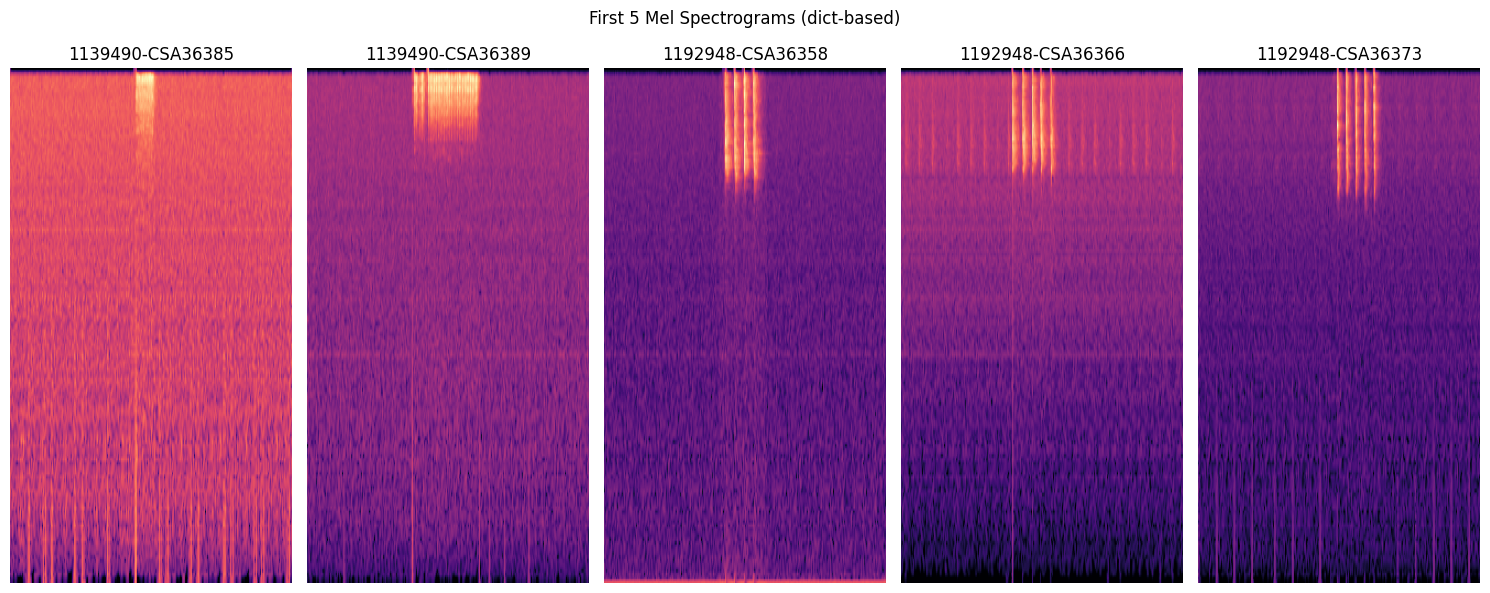

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 読み込みと取り出し
mel_batch = np.load('../data/processed/data_debugs/birdclef2025_melspec_5sec_256_256.npy', allow_pickle=True)
mel_list = mel_batch.item()



keys = list(mel_list.keys())
num_to_show = 5

plt.figure(figsize=(15, 6))
for i in range(num_to_show):
    mel = mel_list[keys[i]]
    plt.subplot(1, num_to_show, i + 1)
    plt.imshow(mel, aspect='auto', origin='lower', cmap='magma')
    plt.title(keys[i])
    plt.axis('off')

plt.suptitle('First 5 Mel Spectrograms (dict-based)')
plt.tight_layout()
plt.show()

